<h1>1. SAGE Publishing</h1>

In this notebook, SAGE publication is analysed using OpenAlex API data. I have approached this in terms of:
<ol>
    <li>Basic query to retireve publications of SAGE over the years and citation information of their published work</li>
    <li>Thereafter, I have concentated on a particular year, i.e., 2022 (last year) and retrieved SAGE published work from that year.</li>
    <li>The analysis is targeted towards identifying the institutions that published the works in SAGE during that year - geographical coverage, type of institution, open access preference, etc. This might help to identify gaps, and open new opportunities for SAGE to increase their customer base.</li>
    <li>I attempted to document the steps involved and also identified some data issue challenges.</li>
</ol>

<h2>1.1 Import Libraries & Configuration</h2>

In [1]:
# numeric library
import numpy as np
# data structure library
import pandas as pd
# plot library: matplotlib
import matplotlib.pyplot as plt

import requests
import os
import pickle
import country_converter as coco
# plot library: plotly
import plotly.express as px

# some custom utility functions are defined inside the helper_utils.py file, which are used in this notebook
from helper_utils import get_filtered_works_one_page, get_filtered_works_full, append_data, get_search_query_response

<h1>2. SAGE Publishing Basic Information</h1>
<h2>2.1 Search Publisher in OpenAlex</h2>

Following the OpenAlex tutorial's Publisher page <a href='https://docs.openalex.org/api-entities/publishers/search-publishers'>here</a>, I have used the <em>Search</em> query parameter with 'sage':<br/>
<a href='https://api.openalex.org/publishers?search=sage'>https://api.openalex.org/publishers?search=sage</a><br/>

That will return a Publisher object, describing everything OpenAlex knows about the publishers matching that search query. Clicking the above link will retrieve JSON object, which contained 2 results - I have inspected them using Browser JSON extension tool:<br/>
<ol>
    <li>The first one with display_name <strong>"SAGE Publishing"</strong></li>
    <li>The second one with display_name <strong>"Russell Sage Foundation"</strong></li>
</ol>

It is evident that the first one is the desired entry. From there, one can get the SAGE publisher with their OpenAlex ID such as:
<ul>
    <li>Get the publisher with the OpenAlex ID P4310320017:<br/> 
        <a href='https://api.openalex.org/publishers/P4310320017'>https://api.openalex.org/publishers/P4310320017</a></li>
    <li>Alternatively, using external IDs of the publisher such as a Wikidata ID:<br/>
        <a href='https://www.wikidata.org/wiki/Q251266'>https://www.wikidata.org/wiki/Q251266</a>
    </li>
    <li>Institutions in OpenAlex are closely linked with the ROR registry. One can find the ROR ID for SAGE as well.<br/>
        <a href='https://ror.org/05534qc24'>https://ror.org/05534qc24</a>
    </li>
</ul>
    
<h1>3 Load SAGE Publisher Works</h1>

I am retrieving the SAGE publisher <em>works</em> from last year, 2022. The filter that I have used, it had only retrieved journal publications during that time.

<h2>3.1 Retrieve Results using the OpenAlex API call</h2>

In [2]:
#sage_id = "https://ror.org/05534qc24"

# using the publisher identifier OpenAlex ID of SAGE retrieve the works
sage_id = 'https://openalex.org/P4310320017'
from_publication_date = '2022'
filtered_works_url, results_page = get_filtered_works_one_page(sage_id, from_publication_date, 'works', email=None)

print('complete URL with filters: {}'.format(filtered_works_url))
print('Retrieved {} works'.format(len(results_page['results'])))

complete URL with filters: https://api.openalex.org/works?filter=locations.source.publisher_lineage:https://openalex.org/P4310320017,publication_year:2022
Retrieved 25 works


In [3]:
# the API returns results as pages where each page contains 25 results
# that is the number shown for the first query result, it will also retrun the number of total works as a metadata
print('Number of works of SAGE for year {}: {}'.format(from_publication_date, results_page['meta']['count']))

# since each API call returns 25 results, the number of API call required to get all results
print('Number of API calls: {}'.format(results_page['meta']['count'] / 25))

Number of works of SAGE for year 2022: 71743
Number of API calls: 2869.72


In [4]:
works = get_filtered_works_full(filtered_works_url)

25 api requests made so far
50 api requests made so far
100 api requests made so far
500 api requests made so far
1000 api requests made so far
1500 api requests made so far
2000 api requests made so far
2500 api requests made so far
2871 api results made in total


<h2>3.2 Saving the Retrieved Results</h2>

This part is to save the retrieved results so that next time, no need to retrieve it via the API call.

In [7]:
if not os.path.isdir('../data'):
     os.mkdir('../data')
with open('../data/sage_works_2022.pickle', 'wb') as outf:
     pickle.dump(works, outf, protocol=pickle.HIGHEST_PROTOCOL)

<h2>3.3 Loading the Saved Results</h2>

This part is to load the already retrieved results so that the steps in Section 3.1 & 3.2 do not need to be repeated.

In [2]:
with open('../data/sage_works_2022.pickle', 'rb') as f:
    works = pickle.load(f)

<h1>4. Load Data into Pandas Dataframe</h1>

In [3]:
data = []
iter_cnt = 0

# this is iterating over each work
# for each work, listing the author of the work
# then for each author - the affiliated institutions....
# that's why the number of entries of the pandas dataframe are much higher than the original number of works retrieved
for work in works:
    # open access details of the work
    work_open_access = work['open_access']['is_oa'] if work['open_access'] else None
    work_open_access_status = work['open_access']['oa_status'] if work['open_access'] else None
    
    # the type of work related to the primary location (journal/conference/....)
    work_type = None
    if work['primary_location']:
        if work['primary_location']['source']:
            work_type = work['primary_location']['source']['type']
            # dehydrated source object does not have 'value_usd' information
            #work_price = work['primary_location']['source']['value_usd']
    
    if work['authorships']:
        for authorship in work['authorships']:
            author = authorship['author']
            author_id = author['id'] if author else None
            author_name = author['display_name'] if author else None
            author_position = authorship['author_position']
            
            if authorship['institutions']:
                for institution in authorship['institutions']:
                    if institution:
                        institution_id = institution['id']
                        institution_name = institution['display_name']
                        institution_country_code = institution['country_code']
                        institution_type = institution['type']
                        append_data(data, work, work_open_access, work_open_access_status, \
                                    work_type, author_id, author_name, author_position, \
                                    institution_id, institution_name, institution_country_code, institution_type)
                    else:
                        append_data(data, work, work_open_access, work_open_access_status, work_type, \
                                    author_id, author_name, author_position, institution_id=None, \
                                    institution_name=None, institution_country_code=None, institution_type=None)
            else:
                append_data(data, work, work_open_access, work_open_access_status, work_type, \
                            author_id, author_name, author_position, institution_id=None, \
                            institution_name=None, institution_country_code=None, institution_type=None)
    else:
        append_data(data, work, work_open_access, work_open_access_status, work_type, \
                    author_id=None, author_name=None, author_position=None, \
                    institution_id=None, institution_name=None, institution_country_code=None, institution_type=None)
    iter_cnt += 1
    
print('Iteration count: {}'.format(iter_cnt))

Iteration count: 71743


In [4]:
# creating the Pandas dataframe
df = pd.DataFrame(data)

print('Dataset shape: {}'.format(df.shape))
print('Number of unique works: {}'.format(df['work_id'].nunique()))
print('Dataset columns ({}): {}'.format(len(df.columns), list(df.columns)))

Dataset shape: (367282, 15)
Number of unique works: 71743
Dataset columns (15): ['work_id', 'work_title', 'work_display_name', 'work_publication_year', 'work_publication_date', 'work_open_access', 'work_open_access_status', 'work_type', 'author_id', 'author_name', 'author_position', 'institution_id', 'institution_name', 'institution_country_code', 'institution_type']


<h1>5. Exploratory Data Analysis (EDA)</h1>

<h2>5.1. Number of SAGE Publications over the years</h2>

In [5]:
# SAGE
# number of publications over the years
sample_url = 'https://api.openalex.org/publishers?search=sage'
results_page = get_search_query_response(sample_url)

df_t = pd.DataFrame(results_page['results'][0]['counts_by_year'])

In [6]:
print('Total published work from {} until {}:\n*****************************************'.format(df_t['year'].min(), df_t['year'].max()))
for r in results_page['results'][0]['roles']:
    print('{}:\t{}'.format(r['role'], r['works_count']))

Total published work from 2012 until 2023:
*****************************************
institution:	65
publisher:	2813406


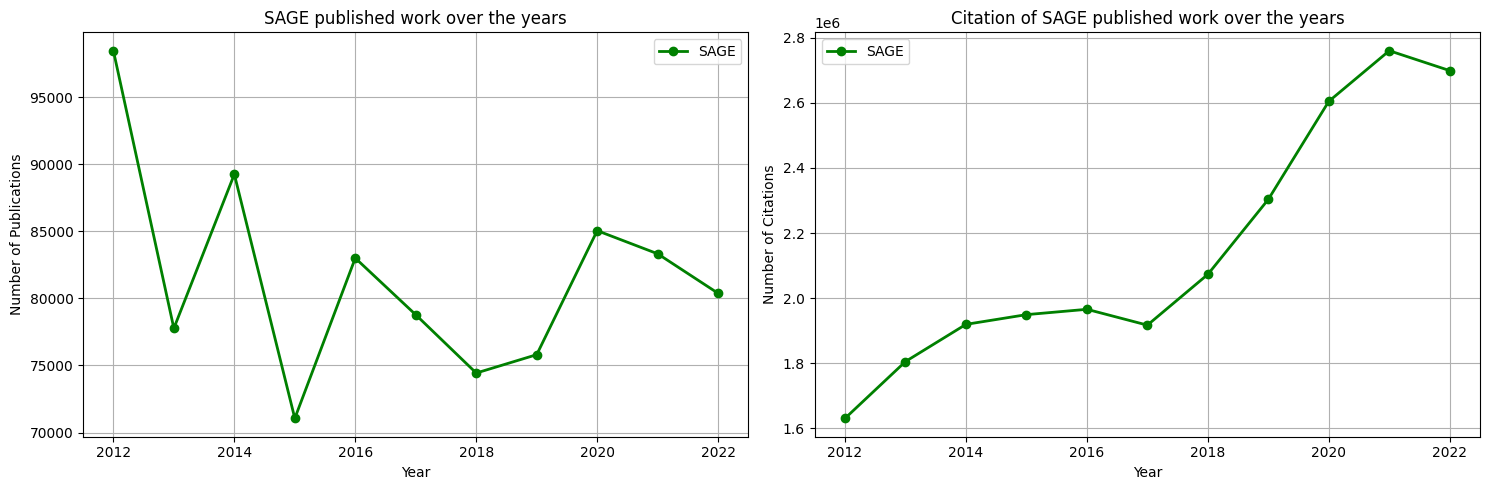

In [7]:
# plotting the fitures: number of published work, citation per year...
# excluding 2023 year
df_t = df_t[df_t['year'] != 2023]
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(df_t['year'], df_t['works_count'], 'go-', linewidth=2, label='SAGE')
axes[1].plot(df_t['year'], df_t['cited_by_count'], 'go-', linewidth=2, label='SAGE')

axes[0].set_xlabel('Year')
axes[0].set_ylabel('Number of Publications')
axes[0].set_title('SAGE published work over the years')

axes[1].set_ylabel('Number of Citations')
axes[1].set_xlabel('Year')
axes[1].set_title('Citation of SAGE published work over the years')

axes[0].grid()
axes[1].grid()
axes[0].legend()
axes[1].legend()

plt.tight_layout()
plt.show()
plt.close()

Decrease of published work over the years, while the citations improved. More selected high quality work have been published recently than before?

<h2>5.2. Analysis of Institutions who Published in SAGE during 2022</h2>

I have picked a particular year, i.e., last year (2022) for the analysis that appears in remainder of this notebook.

In [8]:
print('Number of affiliations not having institution information: {:.2f}%'.format(df['institution_id'].isnull().sum() / df.shape[0] * 100))
# for each work, if there are multiple institutions, remove the duplicate institutions per work_id
temp_df = (df.groupby("work_id", sort=False)["institution_id"]
   .unique()
   .apply(list)
   .reset_index(name="institution_id")
)

print('Dataset shape: {}'.format(temp_df.shape))
print('Number of unique works retrieved using the OpenAlex work filter: {}, while using the search query above it was retrieved as: {}'.format(temp_df.shape[0], df_t[df_t['year']==2022]['works_count'].values[0]))

Number of affiliations not having institution information: 11.18%
Dataset shape: (71743, 2)
Number of unique works retrieved using the OpenAlex work filter: 71743, while using the search query above it was retrieved as: 80381


In [9]:
# flattened institution list -- there were many entries with institution_id as None
flat_inst_list = [item for sublist in temp_df['institution_id'].values for item in sublist]
# removing None/NULL from the list
flat_inst_list = [x for x in flat_inst_list if x is not None]

# creating a dictionary with institution_id and the count of the work during 2022
work_dict = {}
for x in flat_inst_list:
    cnt = 0
    if x in work_dict:
        cnt = work_dict[x]
    work_dict[x] = cnt + 1
    

print('Number of unique institutions: {}'.format(len(np.unique(flat_inst_list))))

Number of unique institutions: 19017


<h3>5.2.1 Top 10 Institutions & Countries Publishing in SAGE during 2022</h3>

In [10]:
# creating a dataframe using institution_id, institution_name and number of works from that institution
temp_df = pd.DataFrame(list(work_dict.items()), columns = ['institution_id', 'count'])
temp_df = temp_df.merge(df[['institution_id', 'institution_name', 'institution_type', 'institution_country_code']], on=['institution_id'], how='left').drop_duplicates(subset=['institution_id'])

# Get the names of the countries from the country codes
cc = coco.CountryConverter()
temp_df['country'] = cc.pandas_convert(temp_df['institution_country_code'], to='name_short')

temp_df.sort_values(by = ['count'], ascending=False).head(10)

,institution_id,count,institution_name,institution_type,institution_country_code,country
46966,https://openalex.org/I185261750,713,University of Toronto,education,CA,Canada
1589,https://openalex.org/I136199984,545,Harvard University,education,US,United States
83626,https://openalex.org/I27837315,503,University of Michigan–Ann Arbor,education,US,United States
30135,https://openalex.org/I165779595,463,University of Melbourne,education,AU,Australia
13342,https://openalex.org/I45129253,427,University College London,education,GB,United Kingdom
58207,https://openalex.org/I141945490,378,University of British Columbia,education,CA,Canada
116830,https://openalex.org/I97018004,372,Stanford University,education,US,United States
3166,https://openalex.org/I79576946,361,University of Pennsylvania,education,US,United States
62794,https://openalex.org/I201448701,356,University of Washington,education,US,United States
15952,https://openalex.org/I40120149,356,University of Oxford,education,GB,United Kingdom


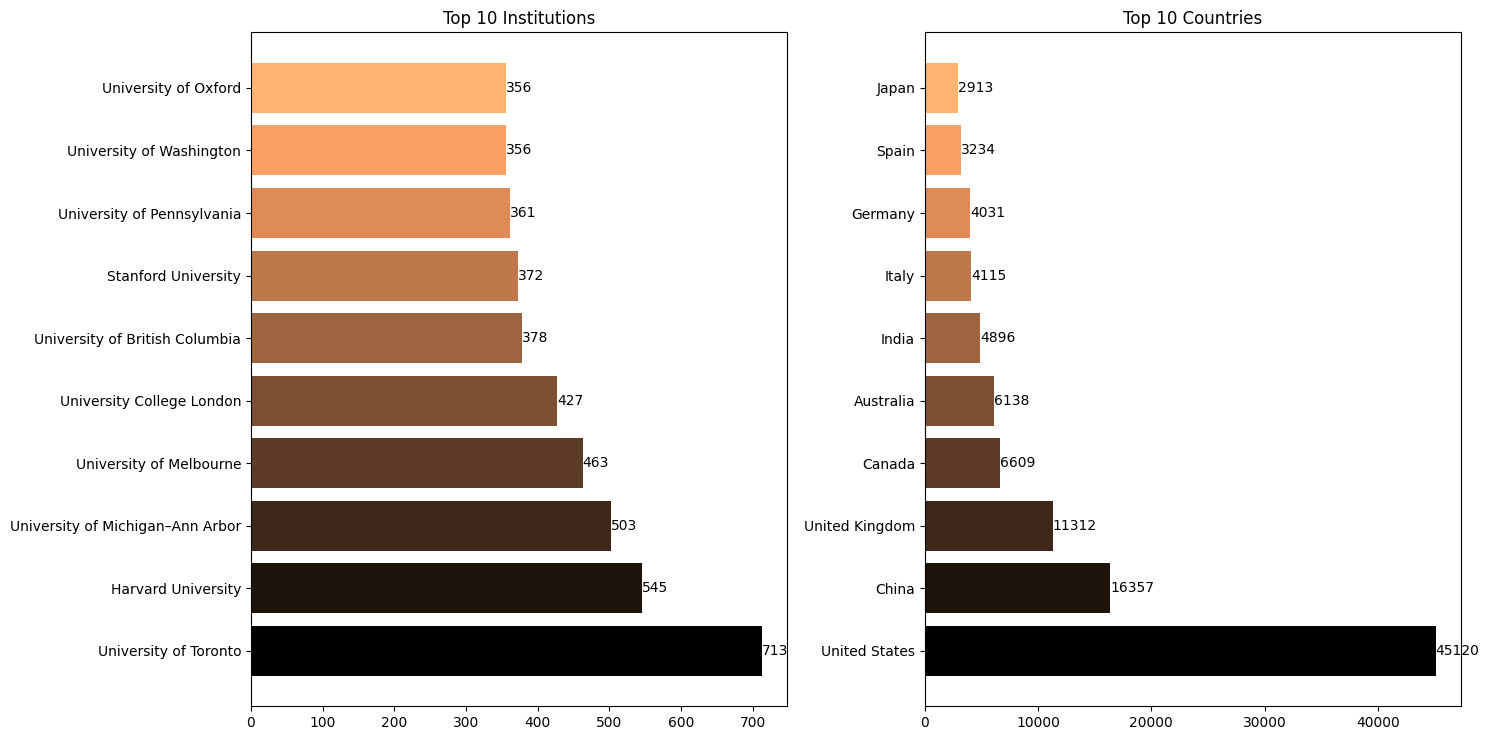

In [11]:
# Top 10 institutions with the most journal publications in SAGE during 2022
indices_ref1 = temp_df.sort_values(by = ['count'], ascending=False).head(10)['institution_name'].tolist()
means1 = temp_df.sort_values(by = ['count'], ascending=False).head(10)['count'].tolist()
indices1 = ['{}'.format(indices_ref1[i]) for i in range(len(indices_ref1))]

country_counts = temp_df.groupby(['country'])['count'].sum().reset_index()
indices_ref2 = country_counts.sort_values(by = ['count'], ascending=False).head(10)['country'].tolist()
means2 = country_counts.sort_values(by = ['count'], ascending=False).head(10)['count'].tolist()
indices2 = ['{}'.format(indices_ref2[i]) for i in range(len(indices_ref2))]

fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))
theme = plt.get_cmap('copper')
#theme = plt.get_cmap('Accent')
colors =  [theme(1. * i / len(means1))
                             for i in range(len(means1))]
rects1 = axes[0].barh(indices1, means1, color=colors)
axes[0].bar_label(rects1)

rects2 = axes[1].barh(indices2, means2, color=colors)
axes[1].bar_label(rects2)

axes[0].set_title('Top 10 Institutions')
axes[1].set_title('Top 10 Countries')
plt.tight_layout()
plt.show()
plt.close()

<h3>5.2.1.1 Choropleth Map Visualistion</h3>

In [22]:
country_counts = temp_df.groupby(['country'])['count'].sum().reset_index()
country_counts = country_counts.merge(temp_df[['institution_country_code', 'country']], on=['country'], how='left').drop_duplicates(subset = ['institution_country_code'])

country_counts['country_code_ISO3'] = cc.pandas_convert(country_counts['institution_country_code'], to='ISO3')

# Make the map
fig = px.choropleth(country_counts, locations='country_code_ISO3', locationmode='ISO-3', color='count', hover_name='country')
fig.show()
#fig.show(renderer='png')

<h3>5.2.3 Institution Type Analysis Publishing in SAGE during 2022</h3>

Unique institution types (8):
['education', 'healthcare', 'nonprofit', 'facility', 'other', 'government', 'company', 'archive', None]


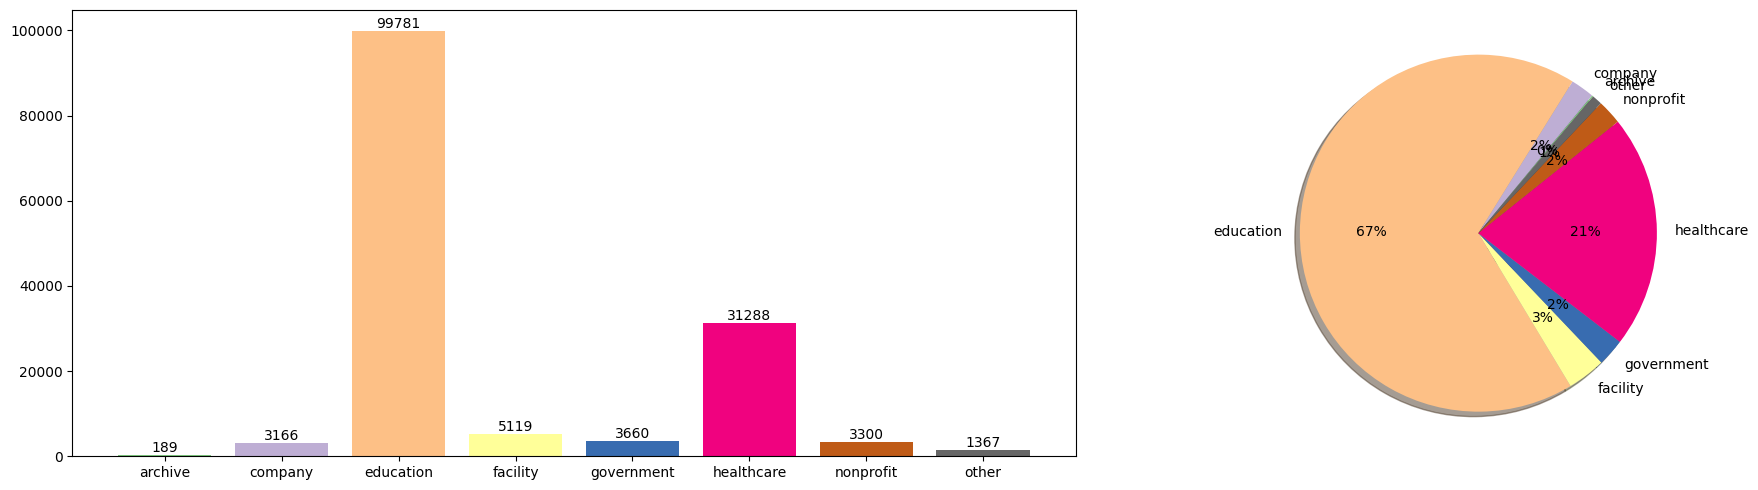

In [13]:
print('Unique institution types ({}):\n{}'.format(temp_df['institution_type'].nunique(), list(temp_df['institution_type'].unique())))
d = temp_df.groupby('institution_type')['count'].sum().to_dict()

# bar graph and pie chart for the Open Access journals in 2022
df_t = pd.DataFrame(d.items(), columns=['institution_type', 'count'])

target_inds = df_t['institution_type'].values
target_vals = df_t['count'].values

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

#theme = plt.get_cmap('copper')
theme = plt.get_cmap('Accent')
colors =  [theme(1. * i / len(target_vals))
                             for i in range(len(target_vals))]
rects1 = axes[0].bar(target_inds, target_vals, color=colors)
axes[0].bar_label(rects1)
axes[1].pie(target_vals, labels=['{}'.format(x) for x,y in zip(target_inds, target_vals)], startangle=50, autopct='%.0f%%', colors=colors, shadow=True)

plt.tight_layout()
plt.show()
plt.close()

<h4>education: institution_type</h4>

In [14]:
country_counts = temp_df[temp_df['institution_type'] == 'education'].groupby(['country'])['count'].sum().reset_index()
country_counts = country_counts.merge(temp_df[['institution_country_code', 'country']], on=['country'], how='left').drop_duplicates(subset = ['institution_country_code'])

country_counts['country_code_ISO3'] = cc.pandas_convert(country_counts['institution_country_code'], to='ISO3')

# Make the map
fig = px.choropleth(country_counts, locations='country_code_ISO3', locationmode='ISO-3', color='count', hover_name='country')
fig.show()
#fig.show(renderer='png')

<h4>nonprofit: institution_type</h4>

In [15]:
country_counts = temp_df[temp_df['institution_type'] == 'nonprofit'].groupby(['country'])['count'].sum().reset_index()
country_counts = country_counts.merge(temp_df[['institution_country_code', 'country']], on=['country'], how='left').drop_duplicates(subset = ['institution_country_code'])

country_counts['country_code_ISO3'] = cc.pandas_convert(country_counts['institution_country_code'], to='ISO3')

# Make the map
fig = px.choropleth(country_counts, locations='country_code_ISO3', locationmode='ISO-3', color='count', hover_name='country')
fig.show()
#fig.show(renderer='png')

<h2>5.3 Open Access Publications in SAGE during 2022</h2>

NULL information inside is_oa (Open Access) field (0): 0.00%


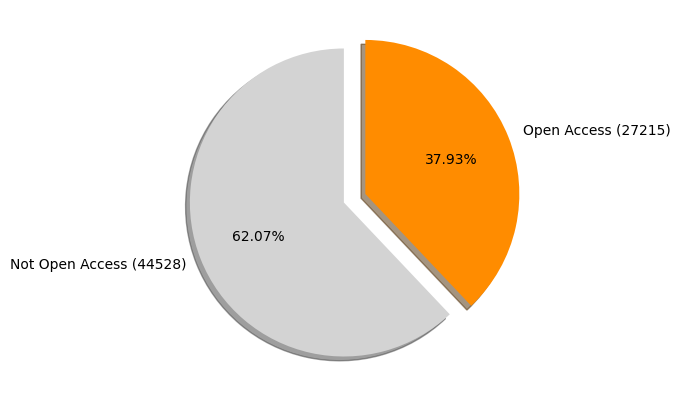

In [16]:
# Pandas dataframe has duplicate work (e.g., for each author/instituation, there is an entry inside the dataframe)
df_removed_duplicate = df.drop_duplicates(subset = ['work_id'])
# NULL perc of the Open Access Information
print('NULL information inside is_oa (Open Access) field ({}): {:.2f}%'.format(df_removed_duplicate['work_open_access'].isnull().sum(), df_removed_duplicate['work_open_access'].isnull().sum() / df_removed_duplicate.shape[0] * 100))

# bar graph and pie chart for the Open Access journals in 2022
target_vals = df_removed_duplicate['work_open_access'].value_counts().values
target_inds = df_removed_duplicate['work_open_access'].value_counts().index
d = {True: 'Open Access', False: 'Not Open Access'}
indices_bar = [d[x] for x in target_inds]

fig, axes = plt.subplots(1, 1, figsize=(20, 5))

#rects1 = axes[0].bar(indices_bar, target_vals, color=['lightgrey', 'darkorange'], edgecolor='darkblue')
axes.pie(target_vals, labels=['{} ({})'.format(d[x], y) for x,y in zip(target_inds, target_vals)], startangle=90, autopct='%.2f%%', explode=[0, 0.15], shadow=True, colors=['lightgrey', 'darkorange'])

#plt.tight_layout()
plt.show()
plt.close()

<h3>5.3.1 Number of Open Access Publications in SAGE during 2022</h3>

In [17]:
count_df = df_removed_duplicate.groupby(['institution_country_code', 'work_open_access']).count()['work_id'].reset_index()
count_df = count_df.rename(columns={'work_id': 'count'})

sum_df = count_df.groupby('institution_country_code').sum()['count'].reset_index()
sum_df = sum_df.rename(columns={'count': 'sum'})
temp_df = count_df.merge(sum_df[['institution_country_code', 'sum']], on=['institution_country_code'], how='left')

temp_df['perc'] = temp_df['count'] / temp_df['sum'] * 100

<h4>5.3.1.1 World Coverage Map [Percentage of Open Access SAGE Publications]</h4>

In [24]:
# Get the names of the countries from the country codes
cc = coco.CountryConverter()
temp_df['country'] = cc.pandas_convert(temp_df['institution_country_code'], to='name_short')
temp_df['country_code_ISO3'] = cc.pandas_convert(temp_df['institution_country_code'], to='ISO3')

# Make the map
fig = px.choropleth(temp_df[temp_df['work_open_access'] == True], locations='country_code_ISO3', locationmode='ISO-3', color='perc', hover_name='country')
fig.show()
#fig.show(renderer='png')

<h4>5.3.1.2 World Coverage Map [Percentage of Not Open Access SAGE Publications]</h4>

In [25]:
# Make the map
fig = px.choropleth(temp_df[temp_df['work_open_access'] == False], locations='country_code_ISO3', locationmode='ISO-3', color='perc', hover_name='country')
fig.show()
#fig.show(renderer='png')

<h1>Summary</h1>

I have looked into SAGE publications and tried to provide an analysis of the institutions that have published during 2022.
I analysed them from their geographical location, open access preference, type of institution to identify SAGE market paradigm, and thereby, form market strategy to increase its customer base.